In [1]:
import torch
import numpy as np

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, time_series, window_size, num_queries):
        self.time_series = time_series
        self.window_size = window_size
        self.num_queries = num_queries

    def __len__(self):
        return self.num_queries

    def __getitem__(self, idx):
        query_idx = torch.randint(high=len(self.time_series) - self.window_size, size=(1,))
        pos_idx = query_idx + torch.randint(low=1, high=self.window_size, size=(1,))
        neg_idx = torch.randint(high=len(self.time_series) - self.window_size, size=(1,))
        while torch.abs(query_idx - neg_idx) < self.window_size:
            neg_idx = torch.randint(high=len(self.time_series) - self.window_size, size=(1,))

        query = self.time_series[query_idx : query_idx + self.window_size]
        pos = self.time_series[pos_idx : pos_idx + self.window_size]
        neg = self.time_series[neg_idx : neg_idx + self.window_size]

        return query, pos, neg

In [3]:
import pandas as pd

data_paths=['/home/maria/NYCCrimesAndTaxis/data/borough_hist_Bronx.csv', 
            '/home/maria/NYCCrimesAndTaxis/data/borough_hist_Brooklyn.csv',
            '/home/maria/NYCCrimesAndTaxis/data/borough_hist_Manhattan.csv', 
            '/home/maria/NYCCrimesAndTaxis/data/borough_hist_Queens.csv',
            '/home/maria/NYCCrimesAndTaxis/data/borough_hist_Staten Island.csv']

dfs = []
for path in data_paths:
    df = pd.read_csv(path)
    dfs.append(df)

# Merge the DataFrames based on the common columns
merged_df = pd.merge(dfs[0], dfs[1], on=['Date', 'DayOfWeekNum'], suffixes=('_Bronx', '_Brooklyn'))
for df in dfs[2:]:
    merged_df = pd.merge(merged_df, df, on=['Date', 'DayOfWeekNum'])

# Drop any duplicate columns that were created during the merge
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]

# Rename the columns to remove the borough names
merged_df.columns = [col.replace('_Bronx', '').replace('_Brooklyn', '').replace('_Manhattan', '').replace('_Queens', '').replace('_Staten Island', '') for col in merged_df.columns]

# Sort the DataFrame by Date
merged_df.sort_values(by='Date', inplace=True)

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('/home/maria/NYCCrimesAndTaxis/data/borough_hist_merged.csv', index=False)


In [5]:
# Drop the Date and DayOfWeek columns
merged_df = merged_df.drop(columns=['Date', 'DayOfWeekNum'])

# Convert the DataFrame to a NumPy array
data = merged_df.to_numpy(dtype=np.float32)


In [18]:
#from tsai.all import *
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class TimeSeriesDataset(Dataset):
    def __init__(self, time_series, window_size=6, num_queries=150):
        self.time_series = time_series
        self.window_size = window_size
        self.num_queries = num_queries

    def __len__(self):
        return self.num_queries

    def __getitem__(self, idx):
        query_idx = torch.randint(high=len(self.time_series) - self.window_size, size=(1,))
        pos_idx = query_idx + torch.randint(low=1, high=self.window_size, size=(1,))
        query = self.time_series[query_idx]
        pos = self.time_series[pos_idx]

        # Generate 6 negative examples that are far away from the query
        neg_indices = []
        while len(neg_indices) < 6:
            neg_idx = torch.randint(high=len(self.time_series) - self.window_size, size=(1,))
            if (torch.abs(query_idx - neg_idx) >= self.window_size) and (torch.abs(pos_idx - neg_idx) >= self.window_size):
                neg_indices.append(neg_idx)
        
        negs = [self.time_series[neg_idx] for neg_idx in neg_indices]

        return query, pos, torch.Tensor(negs)


dataset = TimeSeriesDataset(data)
dataloader = DataLoader(dataset, batch_size=15, shuffle=True)

for batch in dataloader:
    query, pos, neg = batch
    print(neg.shape)

torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])
torch.Size([15, 6, 5])


In [15]:
print(mlp_model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
    (5): ReLU()
  )
)


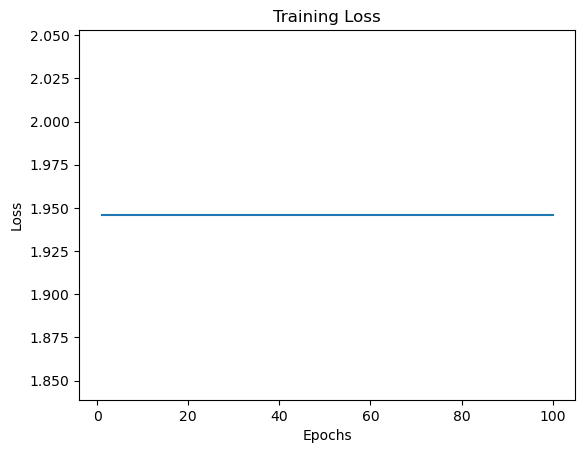

In [19]:
import matplotlib.pyplot as plt
from info_nce import InfoNCE
from torch import nn
# Define model, optimizer, and loss function

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.layers(x)
        #print('x',x.shape)
        return x
    
mlp_model = MLP()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
loss_fn = InfoNCE(negative_mode='paired')

# Define training loop
epochs = 100
train_losses = []
for epoch in range(1, epochs+1):
    epoch_loss = 0
    for batch in dataloader:
        query, pos, neg = batch
        #optimizer.zero_grad()
        query_embed = mlp_model(query)
        pos_embed = mlp_model(pos)
        #print('q',query_embed.shape)
        neg_embed = torch.stack([mlp_model(torch.Tensor(neg[:,j])) for j in range(6)],dim=1)
        #print(neg_embed.shape)
        loss = loss_fn(query_embed, pos_embed, neg_embed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    train_losses.append(epoch_loss)
    #print(f"Epoch {epoch} loss: {epoch_loss:.4f}")

# Plot loss function
plt.plot(range(1, epochs+1), train_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [20]:
a=mlp_model(torch.Tensor(data)).detach().numpy()
print(a)

[[10355.978      0.         0.    ]
 [ 7660.4487     0.         0.    ]
 [ 8985.0205     0.         0.    ]
 ...
 [18242.83       0.         0.    ]
 [13827.049      0.         0.    ]
 [10562.295      0.         0.    ]]


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(a[:,0], a[:,1])
plt.show()

In [ ]:
!pip install ipympl